In [1]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import VGG19_BN_Weights
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import koreanize_matplotlib
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import cv2
import os
import sys
sys.path.append(r'C:\WorkSpace\KDT\TORCH_IMAGE\MyModule\MyModule')
from KDTModule3 import *

In [138]:
#%pip install Flask

  Attempting uninstall: zipp
    Found existing installation: zipp 3.17.0
    Uninstalling zipp-3.17.0:
      Successfully uninstalled zipp-3.17.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

# 이미지 회전해서 증강하기

# 원본 이미지 경로
ROOT_PATH = r'C:\WorkSpace\LocalData\pj_09_DL\train2'
# 회전된 이미지 경로
SAVE_PATH_90 = r'C:\WorkSpace\LocalData\pj_09_DL\train2'

# ImageFolder 사용
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

originDS = datasets.ImageFolder(root=ROOT_PATH)

# for i in range(len(originDS)):
#     for j in [0, 90, 180, 270]:
#         class_name = DS.classes[DS[i][1]]
#         FILE_PATH = os.path.join(SAVE_PATH_90, class_name, f'img_index{i}_{j}.jpg')
#         FILE_PATH2 = os.path.join(SAVE_PATH_90, class_name, f'flip_img_index{i}_{j}.jpg')
#         rotate_img = originDS[i][0].rotate(j, expand=True)
#         flipped_img = rotate_img.transpose(Image.FLIP_LEFT_RIGHT)
#         rotate_img.save(FILE_PATH)
#         flipped_img.save(FILE_PATH2)

# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(DS.classes)
print(f'데이터 개수 : {len(DL.dataset)}')

# 데이터 증강 후에 반복문 주석처리하고 ROOT_PATH를 증강한 이미지 저장된 위치로 변경 => 데이터 갯수 확인 후 학습 시작

['1', '2', '3', '4', '5']
데이터 개수 : 23240


In [3]:
file_path = [i[0] for i in DS.imgs]
labels = [i[1] for i in DS.imgs]

In [4]:
train_path, test_path, train_labels, test_labels = train_test_split(file_path, labels, stratify=labels,
                                                                    random_state = 42, train_size = 0.8)
train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels,
                                                                      stratify=train_labels,
                                                                      random_state = 42, train_size = 0.8)

In [5]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform != None:
            image = self.transform(image)

        # 레이블 불러오기
        label = self.labels[idx]

        return image, label

In [6]:
trainDS = ImagePathDataset(train_path, train_labels, transform=transform)
validDS = ImagePathDataset(valid_path, valid_labels, transform=transform)
testDS = ImagePathDataset(test_path, test_labels, transform=transform)

trainDL = DataLoader(trainDS, batch_size = 32)
validDL = DataLoader(validDS, batch_size = 32)
testDL = DataLoader(testDS, batch_size = 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


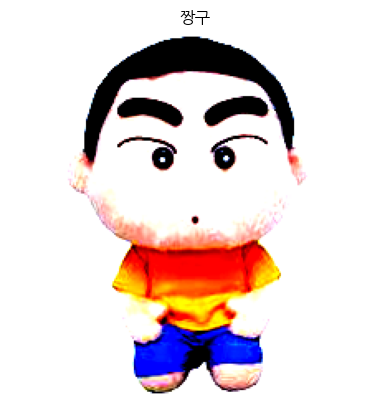

In [7]:
name_dict = {0 : '짱구', 1 : '철수', 2: '훈이' , 3 : '맹구', 4 : '유리'}

INDEX = 100

a = DL.dataset[INDEX][0].permute(1,2,0)
plt.axis('off')
plt.title(name_dict[DL.dataset[INDEX][1]])
plt.imshow(a)
plt.show()

In [8]:
# GPU 사용 가능 여부 확인 
if torch.cuda.is_available():
    print('GPU')
    device = torch.device("cuda")
else:
    print('CPU')
    device = torch.device("cpu")

# 미리 학습된 Vgg 모델 불러오기 (weight 사용)
model = models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).to(device)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

CPU


In [9]:
# 마지막 레이어 (full connected layer) 교체 (클래스 5개)
num_features = model.classifier[0].in_features
model.classifier = nn.Linear(num_features, 5)

# 손실 함수와 옵티마이저 정의
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [13]:
trainDL.dataset[0][0].shape

torch.Size([3, 224, 224])

In [10]:
num_features

25088

In [15]:
EPOCH = 100
SAVE_PATH = r'C:\Users\DELL-PC\Desktop\yunho\model_yunho'

result=training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer,
         epoch = EPOCH, endurance_cnt = 5, view_epoch = 1, num_classes = 5, SAVE_PATH = SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.3686, Test : 0.2389
[Score  : 1/100] Train : 0.8694, Test : 0.9179
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.0668, Test : 0.2067
[Score  : 2/100] Train : 0.9799, Test : 0.9320
[Loss : 3/100] Train : 0.0163, Test : 0.2268
[Score  : 3/100] Train : 0.9980, Test : 0.9244
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.0062, Test : 0.1729
[Score  : 4/100] Train : 1.0000, Test : 0.9479
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/100] Train : 0.0033, Test : 0.1687
[Score  : 5/100] Train : 1.0000, Test : 0.9500
[Loss : 6/100] Train : 0.0023, Test : 0.1690
[Score  : 6/100] Train : 1.0000, Test : 0.9497
[Loss : 7/100] Train : 0.0018, Test : 0.1697
[Score  : 7/100] Train : 1.0000, Test : 0.9484
[Loss : 8/100] Train : 0.0014, Test : 0.1708
[Score  : 8/100] Train : 1.0000, Test : 0.9487
[Loss : 9/100] Train : 0.0011, Test : 0.1720
[Score  : 9/100] Train : 1.0000, Test : 0.9495
[Loss] 값의 개선이 이루어지지 않아 [10] EPOCH에서 학습을 종료합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

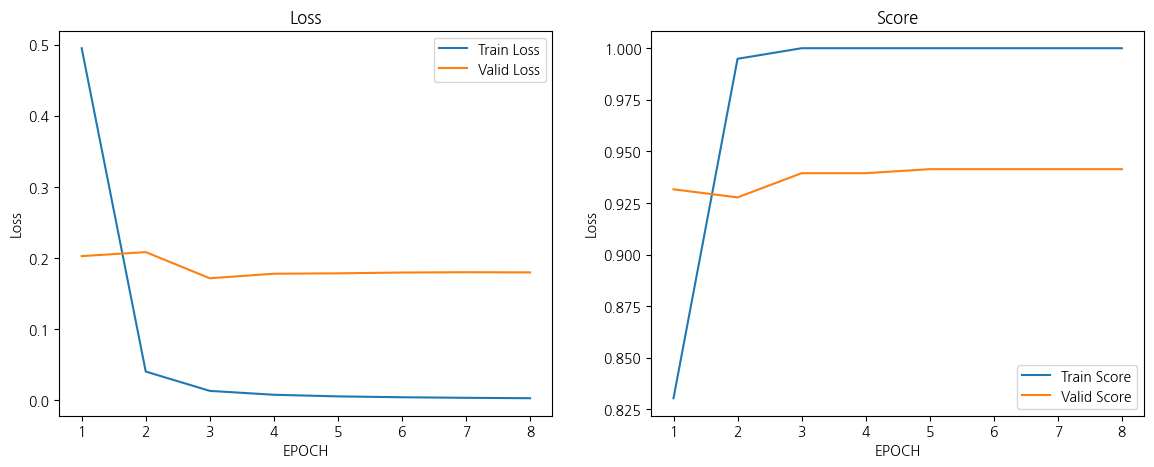

In [23]:
DrawPlot(result)
plt.show

In [11]:
MODEL_PATH=r'C:\WorkSpace\LocalData\pj_09_DL\model\best_model_epoch_5.pth'

In [65]:
best_model = model = models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).to(device)

best_model.classifier = nn.Linear(in_features=25088, out_features=5)

best_model.load_state_dict(torch.load(MODEL_PATH, weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [66]:
input_data = []
target_data = []
for i, j in validDL:
    input_data.append(i)
    target_data.append(j)
    break

In [127]:
input_data[0].shape

torch.Size([32, 3, 224, 224])

In [68]:
pred_value = torch.argmax(best_model(input_data[0]), dim=1)
pred_value

tensor([2, 1, 2, 0, 3, 0, 0, 1, 2, 1, 2, 4, 1, 1, 0, 1, 4, 2, 2, 1, 2, 0, 2, 1,
        4, 4, 4, 2, 2, 3, 2, 2])

In [21]:
{i : DS.classes[i] for i in range(len(DS.classes))}

{0: '1', 1: '2', 2: '3', 3: '4', 4: '5'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


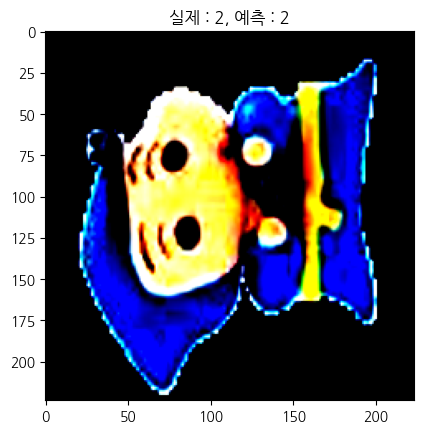

In [137]:
INDEX = 23 # 배치 사이즈 범위 내의 값

name_dict = {i : DS.classes[i] for i in range(len(DS.classes))}
pred_name = name_dict[pred_value[INDEX].item()]
real_name = name_dict[target_data[0][INDEX].item()]
plt.imshow(input_data[0][INDEX].permute(1,2,0))
plt.title(f'실제 : {real_name}, 예측 : {pred_name}')
plt.show()

In [74]:
test_target=[i[0] for i in testDL.dataset]
test_label=[i[1] for i in testDL.dataset]